<a href="https://colab.research.google.com/github/draperdayton20/CompModeling/blob/master/MuskTweets_TeslaStock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Using Elon Musk tweets to predict Tesla stock

For this project, I attempted to predict the direction of change in Tesla stock price using Elon Musk's tweets.

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

stock = pd.read_csv('https://raw.githubusercontent.com/draperdayton20/CompModeling/master/TSLA.csv')
tweets = pd.read_csv('https://raw.githubusercontent.com/draperdayton20/CompModeling/master/usertweets-elon-musk-tweets-QueryResult.csv')

The first step was to figure out how to analyze the tweets.  The following code creates an algorithem that can read text, and assign it a sentiment (either negative or positive).  When doing this, I followed along with a walk-through that can be found [here](https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk).

In [537]:
!pip install nltk==3.3

In [538]:
import nltk
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

This downloads a dataset that countains thousands of tweets, already tagged for their sentiment.

In [0]:
from nltk.corpus import twitter_samples

pos_tweets = twitter_samples.strings('positive_tweets.json')
neg_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')

In [540]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

This section starts by figuring out each word's context in the sentence.  NNP, for example, means "Noun, proper, singular."

In [541]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [542]:
from nltk.tag import pos_tag
print(pos_tag(tweet_tokens[0]))

[('#FollowFriday', 'JJ'), ('@France_Inte', 'NNP'), ('@PKuchly57', 'NNP'), ('@Milipol_Paris', 'NNP'), ('for', 'IN'), ('being', 'VBG'), ('top', 'JJ'), ('engaged', 'VBN'), ('members', 'NNS'), ('in', 'IN'), ('my', 'PRP$'), ('community', 'NN'), ('this', 'DT'), ('week', 'NN'), (':)', 'NN')]


The next step is to take words that have multiple forms (ie dance, dancing, danced), and simplifying them all to one form.  This is called lemmatization.

In [543]:
from nltk.stem.wordnet import WordNetLemmatizer
def lemmatize_sentence(tokens):
  lemmatizer = WordNetLemmatizer()
  lemmatized_sentence = []
  for word, tag in pos_tag(tokens):
    if tag.startswith('NN'):
      pos = 'n'
    elif tag.startswith('VB'):
      pos = 'v'
    else:
      pos = 'a'
    lemmatized_sentence.append(lemmatizer.lemmatize(word,pos))
  return lemmatized_sentence

print(lemmatize_sentence(tweet_tokens[0]))


['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'be', 'top', 'engage', 'member', 'in', 'my', 'community', 'this', 'week', ':)']


Next, we remove 'noise.'  This means any bit of text that doesn't actually help establish meaning, like twitter handles and punctuation.  This also includes stopwords, which are words that don't tend to change the meaning of a phrase, like 'is' and 'a'.

In [0]:
import re, string

def remove_noise(tweet_tokens, stop_words = ()):
    cleaned_tokens = []
    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [545]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [546]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

print(remove_noise(tweet_tokens[0],stop_words))

['#followfriday', 'top', 'engage', 'member', 'community', 'week', ':)']


In [547]:
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

print(positive_tweet_tokens[500])
print(positive_cleaned_tokens_list[500])

['Dang', 'that', 'is', 'some', 'rad', '@AbzuGame', '#fanart', '!', ':D', 'https://t.co/bI8k8tb9ht']
['dang', 'rad', '#fanart', ':d']


Now that the data has been made usable, the real analysis starts.  We can't really do much analysis with just one tweets at a time, so the first step is to put all the words from the positive tweets together, and do the same for the negative tweets.

In [548]:
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

all_pos_words = get_all_words(positive_cleaned_tokens_list)

from nltk import FreqDist

freq_dist_pos = FreqDist(all_pos_words)
print(freq_dist_pos.most_common(10))

[(':)', 3691), (':-)', 701), (':d', 658), ('thanks', 388), ('follow', 357), ('love', 333), ('...', 290), ('good', 283), ('get', 263), ('thank', 253)]


This final part splits the data up into a training and testing set, then trains and tests it.  It also displays the model's accuracy based on the test data, and some of the most positive and negative strings.

In [549]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

import random
positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]
dataset = positive_dataset + negative_dataset
random.shuffle(dataset)
train_data = dataset[:7000]
test_data = dataset[7000:]

from nltk import classify
from nltk import NaiveBayesClassifier

classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))


Accuracy is: 0.997
Most Informative Features
                      :( = True           Negati : Positi =   2051.8 : 1.0
                      :) = True           Positi : Negati =   1665.2 : 1.0
                follower = True           Positi : Negati =     40.3 : 1.0
                     sad = True           Negati : Positi =     22.9 : 1.0
                     bam = True           Positi : Negati =     22.0 : 1.0
                  arrive = True           Positi : Negati =     20.5 : 1.0
              bestfriend = True           Positi : Negati =     14.8 : 1.0
                     idk = True           Negati : Positi =     14.8 : 1.0
                followed = True           Negati : Positi =     14.8 : 1.0
                    sick = True           Negati : Positi =     12.8 : 1.0
None


This section allows us to enter our own "tweets" and see how the model judges them.  It seems to work.

In [550]:
from nltk.tokenize import word_tokenize

custom_tweet = "Computational modeling and simulation is my favorite class, and Byron is such a good teacher."

custom_tokens = remove_noise(word_tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

Positive


In [551]:
custom_tweet = "I have mixed feelings about HD."

custom_tokens = remove_noise(word_tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

Negative


Then, I started applying the sentiment analysis to my data.  Below, I loaded the dataset with all of Elon Musk's tweets.  Then, I put each one through the model, and recorded the sentiment it found.

In [552]:
tweets

,text,username,linktotweet,tweetembedcode,createdat
0,@highqualitysh1t I love the thought of a car d...,elonmusk,http://twitter.com/elonmusk/status/93704198630...,"<blockquote class=""twitter-tweet""><p lang=""en""...",2017-12-02T19:33:00
1,@novaspivack Asimov's Foundation books should ...,elonmusk,http://twitter.com/elonmusk/status/93709071522...,"<blockquote class=""twitter-tweet""><p lang=""en""...",2017-12-02T22:46:00
2,@novaspivack That's certainly the right way to...,elonmusk,http://twitter.com/elonmusk/status/93710961569...,"<blockquote class=""twitter-tweet""><p lang=""en""...",2017-12-03T00:01:00
3,To preserve the transcendent majesty &amp; spe...,elonmusk,http://twitter.com/elonmusk/status/93739733099...,"<blockquote class=""twitter-tweet""><p lang=""en""...",2017-12-03T19:05:00
4,@harrisonlingren @JW8888888 Busted,elonmusk,http://twitter.com/elonmusk/status/93739781363...,"<blockquote class=""twitter-tweet""><p lang=""en""...",2017-12-03T19:07:00
...,...,...,...,...,...
4995,@C3LT_Games Roughly,elonmusk,http://twitter.com/elonmusk/status/11613071123...,"<blockquote class=""twitter-tweet""><p lang=""en""...",2019-08-13T17:02:00
4996,"RT @Tesla: ""I really miss gas stations"" said n...",elonmusk,http://twitter.com/elonmusk/status/11614487607...,"<blockquote class=""twitter-tweet""><p lang=""en""...",2019-08-14T02:25:00
4997,No but srsly don't do it https://t.co/6kXAdGwWsC,elonmusk,http://twitter.com/elonmusk/status/11615255053...,"<blockquote class=""twitter-tweet""><p lang=""en""...",2019-08-14T07:30:00
4998,@acf3301 True,elonmusk,http://twitter.com/elonmusk/status/11615326122...,"<blockquote class=""twitter-tweet""><p lang=""en""...",2019-08-14T07:58:00


In [0]:
sentiments = []
for i in range (len(tweets)):
  custom_tokens = remove_noise(word_tokenize(str(tweets["text"][i])))
  sentiments.append(classifier.classify(dict([token, True] for token in custom_tokens)))

In [554]:
sentiments[:10]

['Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Negative']

Here, I put the date of each tweet next to its sentiment.  I also had to edit the dates a little so that they were standard accross my two datasets.

In [555]:
import numpy as np

dates = [str(i)[0:10] for i in tweets["createdat"]]
data = {'Date':dates, 'Sentiment': sentiments}
tweet_data = pd.DataFrame(data=data)
tweet_data


,Date,Sentiment
0,2017-12-02,Positive
1,2017-12-02,Negative
2,2017-12-03,Negative
3,2017-12-03,Negative
4,2017-12-03,Negative
...,...,...
4995,2019-08-13,Negative
4996,2019-08-14,Negative
4997,2019-08-14,Negative
4998,2019-08-14,Negative


In [556]:
stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
...,...,...,...,...,...,...,...
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300


Here, I first figured out all the days for which the market was open and Elon Musk tweeted.  Then I went through each one of those days and recorded the total number of tweets, the number of positive tweets, and the number of negative tweets.

In [557]:
final_dates = []

dates2 = [str(i)[0:10] for i in tweet_data["Date"]]

for i in range (len(stock["Date"])):
  if stock["Date"][i] in dates2:
    final_dates.append(stock["Date"][i])

count_tot = []
count_pos = []
count_neg = []
stock_change = []
for i in range (len(final_dates)):
  count_tot.append(dates2.count(final_dates[i]))
  a = [k for k,x in enumerate(dates2) if x==final_dates[i]]
  pos_counter = 0
  neg_counter = 0
  for j in a:
    if (tweet_data["Sentiment"][j] == 'Positive'):
      pos_counter = pos_counter + 1
    if (tweet_data["Sentiment"][j] == 'Negative'):
      neg_counter = neg_counter + 1
  count_pos.append(pos_counter)
  count_neg.append(neg_counter)
  b = [k for k,x in enumerate(stock['Date']) if x==final_dates[i]]
  stock_change.append((stock['Close'][b[0]] - stock['Open'][b[0]])/stock['Open'][b[0]] * 100)

data = {'Date':final_dates, 'Number of tweets': count_tot, 'Positive Tweets':count_pos, "Negative Tweets":count_neg, "Stock Change (%)": stock_change}

final_data = pd.DataFrame(data = data)
final_data

,Date,Number of tweets,Positive Tweets,Negative Tweets,Stock Change (%)
0,2017-12-07,1,0,1,-0.243593
1,2017-12-08,4,2,2,0.168468
2,2017-12-11,6,2,4,4.538664
3,2017-12-12,1,0,1,3.201691
4,2017-12-13,2,2,0,-0.557297
...,...,...,...,...,...
381,2019-08-08,7,5,2,1.642144
382,2019-08-09,19,13,6,-0.440588
383,2019-08-13,1,0,1,2.705302
384,2019-08-14,3,0,3,-5.012764


Upon first glance, there doesn't seem to be much of a connection between the tweets and the stock price.

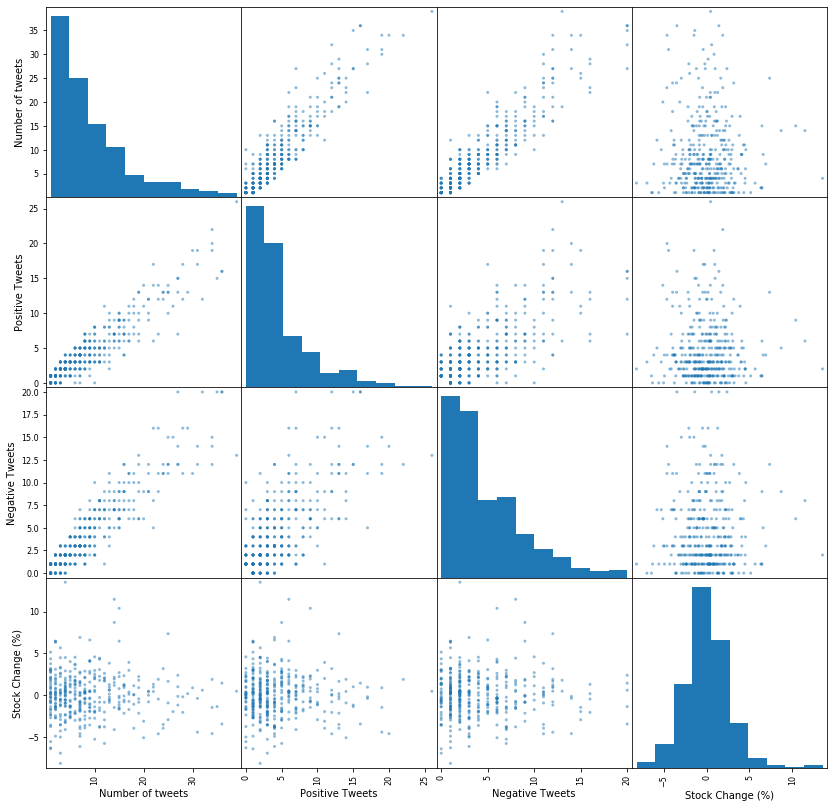

In [558]:
pd.plotting.scatter_matrix(final_data, alpha=0.5, figsize=(14, 14))
plt.show()

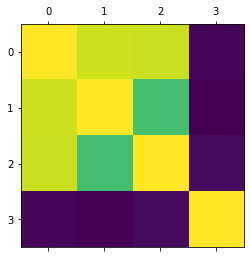

In [559]:
plt.matshow(final_data.corr())
plt.show()

Here, I performed a linear regression, using the tweet data to predict the change in stock price.

In [560]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

x = final_data[ ['Number of tweets','Positive Tweets','Negative Tweets'] ]
y = final_data['Stock Change (%)']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

regressor = LinearRegression()
regressor.fit(x_train, y_train)

y_pred = regressor.predict(x_test)

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results


,Actual,Predicted
260,-0.335690,0.126348
320,-0.850411,-0.031755
144,-0.941769,0.076369
52,-1.475070,-0.073300
210,6.461538,0.051514
...,...,...
302,-0.245715,-0.015066
327,-4.924314,-0.031755
329,-3.199402,0.051424
246,-6.421050,0.043079


Since it really only matters if the stock goes up or down, not by how much, here I switched the predicted data to categorical.

In [561]:
pred_cat = []
for i in range (len(y_pred)):
  if (results['Predicted'].iloc[i] > 0):
    pred_cat.append('Up')
  else:
    pred_cat.append('Down')

results_cat = pd.DataFrame({'Actual': y_test, 'Predicted': pred_cat})
results_cat

,Actual,Predicted
260,-0.335690,Up
320,-0.850411,Down
144,-0.941769,Up
52,-1.475070,Down
210,6.461538,Up
...,...,...
302,-0.245715,Down
327,-4.924314,Down
329,-3.199402,Up
246,-6.421050,Up


Then, I found the accuracy.  It was pretty low.

In [562]:
right = 0
for i in range (len(pred_cat)):
  if (results_cat['Actual'].iloc[i] > 0) and (results_cat['Predicted'].iloc[i] == 'Up'):
    right = right + 1
  if (results_cat['Actual'].iloc[i] < 0) and (results_cat['Predicted'].iloc[i] == 'Down'):
    right = right + 1

print("Accuracy =", right/len(pred_cat))

Accuracy = 0.48717948717948717


This code repreats the whole process 100 times and reports the average accuracy.  Usually, that values is below 0.5, meaning this model is actually worse than just guessing.

In [563]:
N = 100

accuracies = []

for i in range (N):

  x = final_data[ ['Number of tweets','Positive Tweets','Negative Tweets'] ]
  y = final_data['Stock Change (%)']

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = i**2)

  regressor = LinearRegression()
  regressor.fit(x_train, y_train)

  y_pred = regressor.predict(x_test)

  results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

  pred_cat = []
  for i in range (len(y_pred)):
    if (results['Predicted'].iloc[i] > 0):
      pred_cat.append('Up')
    else:
      pred_cat.append('Down')

  results_cat = pd.DataFrame({'Actual': y_test, 'Predicted': pred_cat})

  right = 0
  for i in range (len(pred_cat)):
    if (results_cat['Actual'].iloc[i] > 0) and (results_cat['Predicted'].iloc[i] == 'Up'):
      right = right + 1
    if (results_cat['Actual'].iloc[i] < 0) and (results_cat['Predicted'].iloc[i] == 'Down'):
      right = right + 1
  
  accuracies.append(right/len(pred_cat))

np.mean(accuracies)

0.4605128205128206

I thought maybe relatively uneventful days could be throwing things off, so I removed any days in which the stock price changed by less than 1%.

In [564]:
final_data

,Date,Number of tweets,Positive Tweets,Negative Tweets,Stock Change (%)
0,2017-12-07,1,0,1,-0.243593
1,2017-12-08,4,2,2,0.168468
2,2017-12-11,6,2,4,4.538664
3,2017-12-12,1,0,1,3.201691
4,2017-12-13,2,2,0,-0.557297
...,...,...,...,...,...
381,2019-08-08,7,5,2,1.642144
382,2019-08-09,19,13,6,-0.440588
383,2019-08-13,1,0,1,2.705302
384,2019-08-14,3,0,3,-5.012764


In [565]:
dropped = []
for i in range(len(final_data)):
  if (abs(final_data["Stock Change (%)"][i]) < 1):
    dropped.append(i)

final_data2 = final_data.drop(dropped)
final_data2

,Date,Number of tweets,Positive Tweets,Negative Tweets,Stock Change (%)
2,2017-12-11,6,2,4,4.538664
3,2017-12-12,1,0,1,3.201691
7,2017-12-18,2,1,1,-1.748333
8,2017-12-19,2,1,1,-2.692060
9,2017-12-20,7,2,5,-1.115150
...,...,...,...,...,...
380,2019-08-07,11,6,5,3.055187
381,2019-08-08,7,5,2,1.642144
383,2019-08-13,1,0,1,2.705302
384,2019-08-14,3,0,3,-5.012764


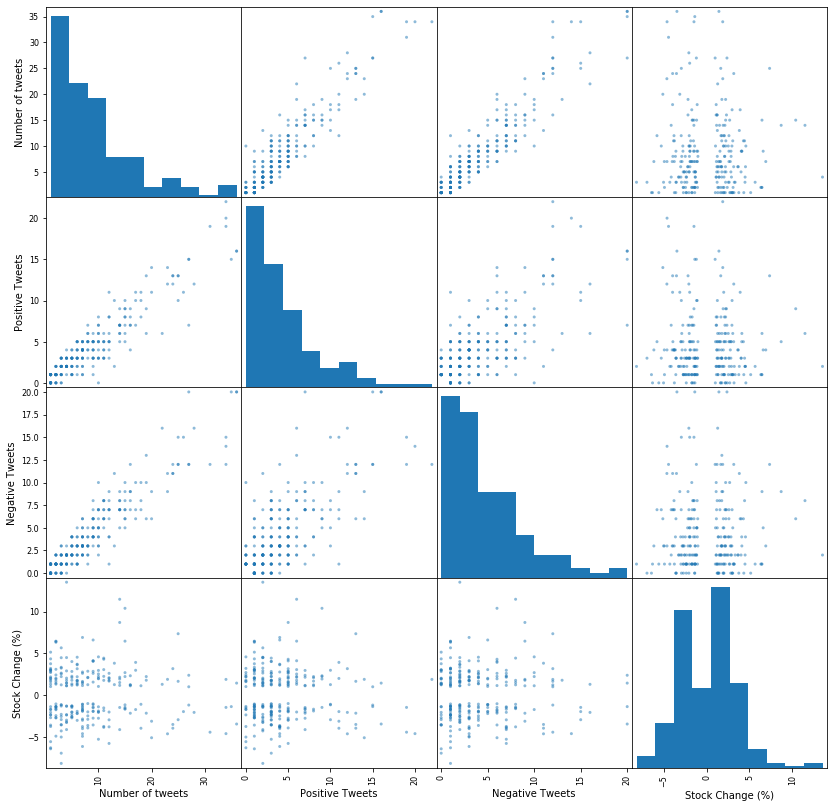

In [566]:
pd.plotting.scatter_matrix(final_data2, alpha=0.5, figsize=(14, 14))
plt.show()

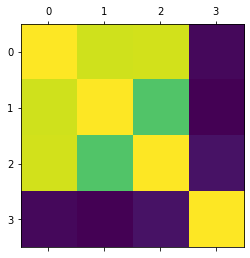

In [567]:
plt.matshow(final_data2.corr())
plt.show()

In [568]:
x = final_data2[ ['Number of tweets','Positive Tweets','Negative Tweets'] ]
y = final_data2['Stock Change (%)']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

regressor = LinearRegression()
regressor.fit(x_train, y_train)

y_pred = regressor.predict(x_test)

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results[:10]

,Actual,Predicted
108,-5.094727,-0.522042
385,-2.363489,0.342184
353,1.544771,-0.024768
243,2.814923,0.179753
143,-3.015761,0.388323
344,1.737277,0.063462
95,-2.206922,0.550753
357,-1.875603,0.137662
276,-1.936167,0.225892
9,-1.115150,0.462523


In [569]:
pred_cat = []
for i in range (len(y_pred)):
  if (results['Predicted'].iloc[i] > 0):
    pred_cat.append('Up')
  else:
    pred_cat.append('Down')

results_cat = pd.DataFrame({'Actual': y_test, 'Predicted': pred_cat})

right = 0
for i in range (len(pred_cat)):
  if (results_cat['Actual'].iloc[i] > 0) and (results_cat['Predicted'].iloc[i] == 'Up'):
    right = right + 1
  if (results_cat['Actual'].iloc[i] < 0) and (results_cat['Predicted'].iloc[i] == 'Down'):
    right = right + 1

print("Accuracy =", right/len(pred_cat))


Accuracy = 0.4117647058823529


The result was... not any better.

In [570]:
accuracies = []

for i in range (N):
  x = final_data2[ ['Number of tweets','Positive Tweets','Negative Tweets'] ]
  y = final_data2['Stock Change (%)']

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = i**2)

  regressor = LinearRegression()
  regressor.fit(x_train, y_train)

  y_pred = regressor.predict(x_test)

  results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

  pred_cat = []
  for i in range (len(y_pred)):
    if (results['Predicted'].iloc[i] > 0):
      pred_cat.append('Up')
    else:
      pred_cat.append('Down')

  results_cat = pd.DataFrame({'Actual': y_test, 'Predicted': pred_cat})

  right = 0
  for i in range (len(pred_cat)):
    if (results_cat['Actual'].iloc[i] > 0) and (results_cat['Predicted'].iloc[i] == 'Up'):
      right = right + 1
    if (results_cat['Actual'].iloc[i] < 0) and (results_cat['Predicted'].iloc[i] == 'Down'):
      right = right + 1
  
  accuracies.append(right/len(pred_cat))

np.mean(accuracies)

0.46392156862745104

Clearly just assigning each tweet a positive or negative sentiment wasn't useful, so I decided to try and use the sentiment analysis algorithem, but alter it to be more usefull.  Instead of using the provided dataset with positive and negative tags, I used Elon Musk's tweets, and tagged them by whether the stock rose or fell on that day.

In [571]:
dates3 = []
text2 = []
change2 = []
for i in range (len(dates2)):
  if dates2[i] in final_data["Date"].tolist():
    dates3.append(dates2[i])
    text2.append(tweets['text'][i])
    change2.append(final_data['Stock Change (%)'][final_data["Date"].tolist().index(dates2[i])])

tweets2 = pd.DataFrame({'Date': dates3, 'Tweets': text2, 'Stock Change (%)': change2})
tweets2


,Date,Tweets,Stock Change (%)
0,2017-12-07,@FortuneTech Do it,-0.243593
1,2017-12-08,@tiamaria68uk Yes,0.168468
2,2017-12-08,"On Tuesday, SpaceX will attempt to fly both an...",0.168468
3,2017-12-08,"On Tuesday, SpaceX will attempt to refly both ...",0.168468
4,2017-12-08,"@tiamaria68uk Plus a towel and a sign saying ""...",0.168468
...,...,...,...
3418,2019-08-13,@C3LT_Games Roughly,2.705302
3419,2019-08-14,"RT @Tesla: ""I really miss gas stations"" said n...",-5.012764
3420,2019-08-14,No but srsly don't do it https://t.co/6kXAdGwWsC,-5.012764
3421,2019-08-14,@acf3301 True,-5.012764


To deal with multiple tweets on the same day, I put all the tweets from each day together.

In [572]:
tweets_p = []
change3 = []
for i in range (len(final_data['Date'])):
  a = [k for k,x in enumerate(dates3) if x==final_dates[i]]
  if (len(a) > 1):
    tweet_tot = ''
    for j in a:
      tweet_tot = tweet_tot + str(text2[j])
    tweets_p.append(tweet_tot)
  else:
    tweets_p.append(text2[i])
  change3.append(final_data['Stock Change (%)'][i])

tweets3 = pd.DataFrame({'Date': final_dates, 'Tweets+': tweets_p, 'Stock Change (%)': change3})
tweets3

,Date,Tweets+,Stock Change (%)
0,2017-12-07,@FortuneTech Do it,-0.243593
1,2017-12-08,"@tiamaria68uk YesOn Tuesday, SpaceX will attem...",0.168468
2,2017-12-11,"Over 30,000 hats sold!After 50k hats, we will ...",4.538664
3,2017-12-12,"On Tuesday, SpaceX will attempt to refly both ...",3.201691
4,2017-12-13,@kaaningilamo Our existence cannot just be abo...,-0.557297
...,...,...,...
381,2019-08-08,RT @cleantechnica: Breaking! IIHS To Crash Tes...,1.642144
382,2019-08-09,RT @Teslarati: Tesla Navigate on Autopilot wit...,-0.440588
383,2019-08-13,Reason RBC question about Model 3 demand is ab...,2.705302
384,2019-08-14,"RT @Tesla: ""I really miss gas stations"" said n...",-5.012764


Then, I tagged each tweet+ by stock change.  I also split up the data into a training and testing set.

In [0]:
import random

up_tweets0 = []
down_tweets0 = []
for i in range (len(tweets3['Stock Change (%)'])):
  if (tweets3['Stock Change (%)'][i] > 0):
    up_tweets0.append(tweets_p[i])
  else:
    down_tweets0.append(tweets_p[i])

random.shuffle(up_tweets0)
random.shuffle(down_tweets0)

up_tweets = up_tweets0[:round((len(up_tweets0)*.8))]
down_tweets = down_tweets0[:round((len(down_tweets0)*.8))]

Then, the code analyzes the tweets and creates a model.

In [0]:


pos_tweets = up_tweets
neg_tweets = down_tweets
text = twitter_samples.strings('tweets.20150430-223406.json')

def lemmatize_sentence(tokens):
  lemmatizer = WordNetLemmatizer()
  lemmatized_sentence = []
  for word, tag in pos_tag(tokens):
    if tag.startswith('NN'):
      pos = 'n'
    elif tag.startswith('VB'):
      pos = 'v'
    else:
      pos = 'a'
    lemmatized_sentence.append(lemmatizer.lemmatize(word,pos))
  return lemmatized_sentence

def remove_noise(tweet_tokens, stop_words = ()):
  cleaned_tokens = []
  for token, tag in pos_tag(tweet_tokens):
      token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                      '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
      token = re.sub("(@[A-Za-z0-9_]+)","", token)
      
      if tag.startswith("NN"):
          pos = 'n'
      elif tag.startswith('VB'):
          pos = 'v'
      else:
          pos = 'a'
      lemmatizer = WordNetLemmatizer()
      token = lemmatizer.lemmatize(token, pos)

      if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
          cleaned_tokens.append(token.lower())
  return cleaned_tokens

stop_words = stopwords.words('english')

positive_tweet_tokens = []

for i in range (len(up_tweets)):
  positive_tweet_tokens.append(nltk.word_tokenize(up_tweets[i]))

negative_tweet_tokens = []

for i in range (len(down_tweets)):
  negative_tweet_tokens.append(nltk.word_tokenize(down_tweets[i]))

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]
dataset = positive_dataset + negative_dataset
random.shuffle(dataset)
train_data = dataset

from nltk import classify
from nltk import NaiveBayesClassifier

classifier = NaiveBayesClassifier.train(train_data)


I played around with custom tweets for a while to see how well the model functions.  The dataset is pretty small, so predictably, it's so-so.

In [582]:
custom_tweet = "We are making cool cars!"

custom_tokens = remove_noise(word_tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

Positive


In [594]:
custom_tweet = "The factory is broken"

custom_tokens = remove_noise(word_tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

Positive


In [593]:
custom_tweet = "All the cars are broken"

custom_tokens = remove_noise(word_tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

Negative


Then, I put each tweet+ through the model.

In [0]:
sentiments2 = []
for i in range (len(tweets_p)):
  custom_tokens = remove_noise(word_tokenize(str(tweets_p[i])))
  if (classifier.classify(dict([token, True] for token in custom_tokens)) == 'Positive'):
    sentiments2.append('Up')
  else:
    sentiments2.append('Down')


Finally, I used the testing set to determine the accuracy of the model.  I didn't repreat the whole thing 100 times like I did earlier, but I tend to get results around 0.5, meaning once again the model is no better than guessing.

In [585]:
test_tweets = up_tweets0[round((len(up_tweets0)*.8)):] + down_tweets0[round((len(down_tweets0)*.8)):]

test_dates = []
test_changes = []
test_sentiments = []
for i in range (len(test_tweets)):
  a = [k for k,x in enumerate(tweets3['Tweets+']) if x==test_tweets[i]]
  test_dates.append(tweets3["Date"][a[0]])
  test_changes.append(tweets3["Stock Change (%)"][a[0]])
  test_sentiments.append(sentiments2[a[0]])

test = pd.DataFrame(data = {'Date':test_dates, 'Tweets+':test_tweets,'Prediction': test_sentiments, 'Stock Change (%)':test_changes})
test

,Date,Tweets+,Prediction,Stock Change (%)
0,2019-01-10,Tesla *with* Autopilot engaged is twice as saf...,Down,3.160887
1,2019-01-11,Starship test flight rocket just finished asse...,Up,1.511302
2,2019-07-23,Time to face reality https://t.co/WOzE2XwlQvht...,Up,1.347833
3,2019-03-21,@TeslaGong Probably start Australia builds in ...,Down,0.520904
4,2018-04-26,@GameOfThrones Don't make me use my space lase...,Down,2.414354
...,...,...,...,...
72,2018-02-21,@lorengrush @T28058389 @VP @blueorigin @ulalau...,Down,-0.812431
73,2019-05-01,@paulg Good question@S100D27 @paulg @CNBC @cha...,Down,-2.026381
74,2018-05-18,Excited for @boringcompany partnership with LA...,Down,-2.750742
75,2018-04-06,Nothing will affect the future of humanity mor...,Up,-0.564788


In [586]:
right = 0
for i in range (len(test_dates)):
  if (test_sentiments[i] == 'Up') and (test_changes[i] > 0):
    right = right + 1
  if (test_sentiments[i] == 'Down') and (test_changes[i] < 0):
    right = right + 1

print(right/len(test_dates))

0.4805194805194805
